# Membrane MD Analysis tutorial using BioExcel Building Blocks (biobb)

***
This tutorial aims to illustrate the process of **analyzing a membrane molecular dynamics (MD) simulation** using the **BioExcel Building Blocks library (biobb)**. The particular example used is the heteropentameric ligand-gated chloride channel gated by gamma-aminobutyric acid (**GABA**), a major inhibitory neurotransmitter in the brain, which was embedded in a **DPPC membrane** in the [MemProtMD](https://memprotmd.bioch.ox.ac.uk/_ref/PDB/4cof/_sim/4cof_default_dppc/) project, which trajectory is obtained from the [**MDDB**](https://mddbr.eu/), where we can find it under the [A01M6](https://mmb-dev.mddbr.eu/#/id/A01M6/overview) accession id.
***

## Settings

### Biobb modules used

 - [biobb_mem](https://github.com/bioexcel/biobb_mem): Tools to fetch biomolecular data from public databases.
 
### Auxiliary libraries used

* [jupyter](https://jupyter.org/): Free software, open standards, and web services for interactive computing across all programming languages.
* [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
* [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_mem.git
cd biobb_wf_mem
conda env create -f conda_env/environment.yml
conda activate biobb_wf_mem
jupyter-notebook biobb_wf_mem/notebooks/biobb_wf_mem.ipynb
```

***
## Pipeline steps
 1. [Input Parameters](#input)
 2. [Fetching Structure and Trajectory](#fetch)
 3. [Fitting](#fitting)
 4. [Membrane Identification with FATSLiM](#fatslim)
 5. [Area per lipid](#apl)
 6. [Leafleats Assignation](#leaflets)
 7. [Z Positions and Membrane Thickness](#thickness)
 8. [Flip-flop rate](#flip-flop)
 9. [Deuterium order parameter](#order)
 10. [Density Profile](#density)
 11. [Channel Dimensions](#channel)
 12. [Questions & Comments](#questions)

***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


<a id="input"></a>
## Input parameters

**Input parameters** needed:
 - **MD_id**: MDDB id of the protein trajectory (e.g. [A01M6](https://mmb-dev.mddbr.eu/#/id/A01M6/overview)).
- **steps**: number of frames to skip during analysis.
 - **lipid_sel**: a [MDAnalysis selection](https://docs.mdanalysis.org/stable/documentation_pages/selections.html) of the headgroups the residues on the topology corresponding to the membrane.
 - **ngl_sel**: and **ngl_hd_sel**: [NGLView](http://nglviewer.org/ngl/api/manual/selection-language.html) selection to visualize the membrane.

In [1]:
# Common imports
import os, requests
import pandas as pd
import numpy as np
import nglview as nv
import MDAnalysis as mda
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import HBox

MD_id = 'A01M6'
steps = 1500
lipid_sel = '(resname DPPC and name P8)'
ngl_sel = 'DPPC'
ngl_hd_sel = f'{ngl_sel} and _P'

# Common arguments for all the components
input_top_path = f'data/{MD_id}.pdb'
input_tpr_path = f'data/{MD_id}.tpr'
input_traj_path = f'data/{MD_id}.xtc'

# If you want to disable the logs, set this variable to True    
disable_logs = False

For the **lipid_sel**, we choose not only choose the residues with name DPPC, but also the atom name P8, as this is the most charged one. Selecting only the headgroups make easier for the algorithms to separate the components of the membrane. 

![DPPC](../html/DPPC.png "DPPC")

<a id="fetch"></a>
***
## Fetching structure and trajectory

Download the structure and trajectory data, in **PDB** and **XTC** formats respectively, from the MD using the [MDDB API](https://mmb-dev.mddbr.eu/api/rest/docs/).

In [2]:
# Check if folders 'out' and 'tmp' exist and create them if not
for folder in ['out', 'data']:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")

# Check if PDB and XTC files already exist
if not os.path.exists(input_top_path):
    # Download PDB
    headers = {'accept': 'chemical/x-pdb'}
    url = f"https://irb.mddbr.eu/api/rest/v1/projects/{MD_id}/files/structure.pdb"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        pdb_content = response.text
        # Save the PDB content to a file
        with open(input_top_path, 'w') as pdb_file:   
            pdb_file.write(pdb_content)
        print(f"Saved PDB file")
    else:
        print(f"Error for the PDB file: {response.status_code}")

if not os.path.exists(input_traj_path): 
    # Download XTC
    headers2 = {'accept': 'application/octet-stream'}
    url2= f'https://irb.mddbr.eu/api/rest/v1/projects/{MD_id}/files/trajectory.xtc'
    response2 = requests.get(url2, headers=headers2)
    if response2.status_code == 200:
        xtc_content = response2.content
        with open(input_traj_path, 'wb') as xtc_file:
            xtc_file.write(xtc_content)
        print(f"Saved XTC file")
    else:
        print(f"Error for the XTC file: {response2.status_code}")

if not os.path.exists(input_tpr_path): 
    # Download XTC
    headers2 = {'accept': 'application/octet-stream'}
    url2= f'https://irb.mddbr.eu/api/rest/v1/projects/{MD_id}/files/topology.tpr'
    response2 = requests.get(url2, headers=headers2)
    if response2.status_code == 200:
        xtc_content = response2.content
        with open(input_tpr_path, 'wb') as xtc_file:
            xtc_file.write(xtc_content)
        print(f"Saved TPR file")
    else:
        print(f"Error for the TPR file: {response2.status_code}")

Saved PDB file
Saved XTC file
Saved TPR file


In [3]:
# Load the trajectory
u = mda.Universe(input_top_path, input_traj_path)

In [4]:
# Visualize the trajectory
view = nv.show_mdanalysis(u)
view.layout.width = '100%'
# Visualize only the lipids with the headgroups in white
view_mem = nv.show_mdanalysis(u)
view_mem.layout.width = '100%'
view_mem.clear_representations()
view_mem.add_representation('licorice', selection=ngl_sel, color='blue')
view_mem.add_ball_and_stick(selection=ngl_hd_sel, color='white',aspect_ratio=4) # headgroups
HBox([view, view_mem])

<a id="fitting"></a>
***
## Fitting the membrane

Fitting the trajectory so the membrane is aligned with the xy plane and the thickness with the z axis.

In [5]:
# We fit the trajectory to the membrane so the z axis is aligned with the membrane
print(f'gmx trjconv -s {input_top_path} -f {input_traj_path} -o data/fit.xtc -fit rot+trans') # Choose 13 DPPC and 0 System
# We fit again transxy to the protein so the it does not shake due to lipids going through the pbc
print(f'gmx trjconv -s {input_top_path} -f data/fit.xtc -o data/fit2.xtc -fit transxy')  # 2/4 Protein/backbone and 0 System

gmx trjconv -s data/A01M6.pdb -f data/A01M6.xtc -o data/fit.xtc -fit rot+trans
gmx trjconv -s data/A01M6.pdb -f data/fit.xtc -o data/fit2.xtc -fit transxy


In [6]:
input_traj_path = 'data/fit2.xtc'

<a id="fatslim"></a>
***
## Membrane identification with FATSLiM

Membrane and leaflets identification.<br>
Knowing the name of our lipids may be not enough to identify the membrane. There may be more than one membrane, cuved ones, lipids outside membranes...
***
**Building Blocks** used:
 - [FatslimMembranes](https://biobb-mem.readthedocs.io/en/latest/fatslim.html#module-fatslim.fatslim_membranes) from **biobb_mem.fatslim.fatslim_membranes**
***

In [7]:
# Analysis function
from biobb_mem.fatslim.fatslim_membranes import fatslim_membranes
# Visualization function
from biobb_mem.fatslim.fatslim_membranes import display_fatslim

### FATSLiM examples
Some different case of membranes with FATSLiM

In [8]:
# From https://github.com/FATSLiM/fatslim/tree/master/fatslimlib/test/data
if not os.path.exists(f"data/bilayer_multi.gro"):
    !wget https://raw.githubusercontent.com/FATSLiM/fatslim/refs/heads/master/fatslimlib/test/data/bilayer_multi.gro -P data

if not os.path.exists(f"data/dppc_vesicle.gro"):
    !wget https://raw.githubusercontent.com/FATSLiM/fatslim/refs/heads/master/fatslimlib/test/data/dppc_vesicle.gro -P data

# From https://cgmartini.nl/docs/downloads/example-applications/micelles.html:
if not os.path.exists(f"data/dpc.gro"):
    !wget https://cgmartini-library.s3.ca-central-1.amazonaws.com/1_Downloads/example_applications/micelles/dpc.gro -P data

--2025-02-11 16:15:50--  https://raw.githubusercontent.com/FATSLiM/fatslim/refs/heads/master/fatslimlib/test/data/bilayer_multi.gro
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549938 (537K) [text/plain]
Saving to: ‘data/bilayer_multi.gro’

bilayer_multi.gro   100%[===================>] 537.05K  --.-KB/s    in 0.04s   

2025-02-11 16:15:55 (14.9 MB/s) - ‘data/bilayer_multi.gro’ saved [549938/549938]

--2025-02-11 16:15:55--  https://raw.githubusercontent.com/FATSLiM/fatslim/refs/heads/master/fatslimlib/test/data/dppc_vesicle.gro
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP 

In [9]:
lipid_sel_CG='name PO4'
prop_CG = {
        'selection': lipid_sel_CG,
        'disable_logs': disable_logs
    }
tops  = ['data/bilayer_multi.gro', 'data/dppc_vesicle.gro','data/dpc.gro']
outs  = ['out/bilayer_multi.ndx', 'out/dppc_vesicle.ndx','out/dpc.ndx']
views = []
for top,out in zip(tops, outs):
    fatslim_membranes(input_top_path=top,
                    output_ndx_path=out,
                    properties=prop_CG)
    view = display_fatslim(top,lipid_sel_CG,output_ndx_path=out, leaflets=True)
    view.add_ball_and_stick(selection='.PO4', color='white') # headgroups
    view.background = 'black'
    view.layout.width = '100%'
    views.append(view)

2025-02-11 16:16:00,627 [MainThread  ] [INFO ]  Module: biobb_mem.fatslim.fatslim_membranes Version: 5.0.6
2025-02-11 16:16:00,628 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_4ad5b9f8-f11f-45c3-8948-5f41fe420f40 directory successfully created
2025-02-11 16:16:00,629 [MainThread  ] [INFO ]  Copy: data/bilayer_multi.gro to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_4ad5b9f8-f11f-45c3-8948-5f41fe420f40
2025-02-11 16:16:00,696 [MainThread  ] [INFO ]  fatslim membranes -n 5272b738-fb57-4ee0-81c9-75407beebebe/headgroups.ndx -c /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_4ad5b9f8-f11f-45c3-8948-5f41fe420f40/bilayer_multi.gro --output-index 39a08245-2816-4a9d-8044-1374af833e3e/output.ndx --cutoff 2 --begin-frame -1 --end-frame -1

2025-02-11 16:16:00,959 [MainThread  ] [INFO ]  Executing: fatslim membranes -n 5272b738-fb57-4ee0-81c9-75407beebebe/headgroups.ndx -c /hom...
2025-02-11 16:16:00,960 [MainThread  ] [IN

In red the lipids that do not correspond to any membrane

In [10]:
# In red: elements not in a membrane. In the third case, 
# the micelle is not identify as membrane.
HBox(views)

### Our case

In [11]:
prop = {
    'selection': lipid_sel,
    'cutoff': 2.2,
    'ignore_no_box': True,
    'disable_logs': disable_logs
}
fatslim_membranes(input_top_path=input_top_path,
                  input_traj_path=input_traj_path,
                  output_ndx_path="out/leaflets.ndx",
                  properties=prop)

2025-02-11 16:16:16,446 [MainThread  ] [INFO ]  Module: biobb_mem.fatslim.fatslim_membranes Version: 5.0.6
2025-02-11 16:16:16,447 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_a6b8e5bd-fe96-4330-a405-a7b144f11983 directory successfully created
2025-02-11 16:16:16,450 [MainThread  ] [INFO ]  Copy: data/A01M6.pdb to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_a6b8e5bd-fe96-4330-a405-a7b144f11983
2025-02-11 16:16:17,565 [MainThread  ] [INFO ]  Copy: data/fit2.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_a6b8e5bd-fe96-4330-a405-a7b144f11983
Setting box dimensions using the minimum and maximum positions of the atoms.
2025-02-11 16:16:17,802 [MainThread  ] [INFO ]  gmx editconf -f /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_a6b8e5bd-fe96-4330-a405-a7b144f11983/A01M6.pdb -o b2e280bc-e7a5-4525-9fd4-c0a5e5226657/output.gro -box 167.68 173.51001 126.630005 ; fatslim membranes -n 91b3c745-a914

0

In [12]:
# We can now visualize the leaflets and the categorizing of the lipids
# There is one lipid that is not in a leaflet, this can be used as a quality 
# check or in case we may want to ignore for the rest of the analyses.
view = display_fatslim(input_top_path,lipid_sel,output_ndx_path="out/leaflets.ndx")
view.add_ball_and_stick(selection=ngl_hd_sel, color='white',aspect_ratio=4) # headgroups
view.layout.height = '400px'
view

NGLWidget(layout=Layout(height='400px'))

In [13]:
# To extract the lipids in each leaflet, we can use the parse_index function
from biobb_mem.fatslim.fatslim_membranes import parse_index
parse_index??
# We can use this atom indeces to select the lipids in the membrane.
# For simplicity, we keep using our previous selection.
# For and example of how to use the indeces, you can see display_fatslim??

Signature: parse_index(ndx)
Source:   
def parse_index(ndx):
    """
    Parses a GROMACS index file (.ndx) to extract leaflet groups.

    Args:
        ndx (str): Path to the GROMACS index file (.ndx).
    Returns:
        dict: A dictionary where keys are group names for each leaflet in format "membrane_1_leaflet_1" and values are lists of integers representing atom indices starting from 1.
    """

    # Read the leaflet.ndx file
    with open(ndx, 'r') as file:
        leaflet_data = file.readlines()

    # Initialize dictionaries to store leaflet groups
    leaflet_groups = {}
    current_group = None

    # Parse the leaflet.ndx file
    for line in leaflet_data:
        line = line.strip()
        if line.startswith('[') and line.endswith(']'):
            current_group = line[1:-1].strip()
            leaflet_groups[current_group] = []
        elif current_group is not None:
            leaflet_groups[current_group].extend(map(int, line.split()))
    return leaflet_groups
File

<a id="apl"></a>
***
## Area per lipid

Area per lipid via a 2D Voronoi tessellation.<br>
While diving the space for the lipids we remove the area correspoding to protein molecules.
***
**Building Blocks** used:
 - [FatslimAPL](https://biobb-mem.readthedocs.io/en/latest/fatslim.html#module-fatslim.fatslim_apl) from **biobb_mem.fatslim.fatslim_apl**
***

In [14]:
from biobb_mem.fatslim.fatslim_apl import fatslim_apl

prop = {
    'lipid_selection': lipid_sel,
    'protein_selection': 'protein and not element H',
    'ignore_no_box': True,
    'disable_logs': disable_logs
}
fatslim_apl(input_top_path=input_top_path,
            input_traj_path=input_traj_path,
            output_csv_path='out/apl.csv',
            properties=prop)

2025-02-11 16:16:37,424 [MainThread  ] [INFO ]  Module: biobb_mem.fatslim.fatslim_apl Version: 5.0.6
2025-02-11 16:16:37,425 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_48f06f64-8d7a-4d29-bb18-986e75fb3d0d directory successfully created
2025-02-11 16:16:37,428 [MainThread  ] [INFO ]  Copy: data/A01M6.pdb to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_48f06f64-8d7a-4d29-bb18-986e75fb3d0d
2025-02-11 16:16:38,503 [MainThread  ] [INFO ]  Copy: data/fit2.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_48f06f64-8d7a-4d29-bb18-986e75fb3d0d
Setting box dimensions using the minimum and maximum positions of the atoms.
2025-02-11 16:16:38,787 [MainThread  ] [INFO ]  gmx editconf -f /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_48f06f64-8d7a-4d29-bb18-986e75fb3d0d/A01M6.pdb -o 4c2c094c-0f56-4444-976a-8b98cbfa84fa/output.gro -box 167.68 173.51001 126.630005 ; fatslim apl -n 8b1a0639-3306-4f25-867b-3

0

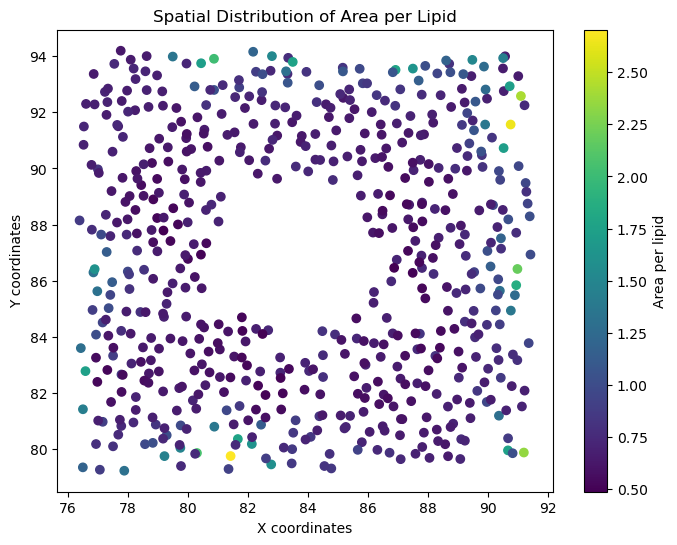

In [6]:
# Load the data
df = pd.read_csv('out/apl.csv')

# Scatter plot of spatial distribution
plt.figure(figsize=(8,6))
plt.scatter(df['X coords'], df['Y coords'], c=df['Area per lipid'], cmap='viridis')
plt.colorbar(label='Area per lipid')
plt.xlabel('X coordinates'); plt.ylabel('Y coordinates')
plt.title('Spatial Distribution of Area per Lipid')
plt.show()

In [ ]:
from scipy.interpolate import griddata

def plot_apl(output_csv_path, hist=False, res=70j):
    """Create a 2D visualization of the area per lipid for both membrane leaflets.

    This function reads area per lipid data from a CSV file, creates interpolated 
    2D maps for both upper and lower leaflets, and displays them side-by-side.

    Parameters
    ----------
    output_csv_path : str
        Path to the CSV file containing area per lipid data
    hist : bool, optional
        If True, use imshow for visualization, otherwise use contourf (default False)
    res : complex, optional
        Grid resolution for interpolation (default 70j)

    Returns
    -------
    list
        List of interpolated grids for upper and lower leaflets
    """
    df = pd.read_csv(output_csv_path)
    grids = []
    # Create separate plots for each leaflet
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True, sharex=True)
    m = df['Area per lipid'].median()
    s = df['Area per lipid'].std()
    vmin, vmax = max(0, m-s), m+s
    # Define common grid for both plots
    x_all = df['X coords']
    y_all = df['Y coords']
    grid_x, grid_y = np.mgrid[min(x_all):max(x_all):res,
                             min(y_all):max(y_all):res]
    for ax, leaflet in zip([ax1, ax2], ['upper leaflet','lower leaflet']):
        df_leaflet = df[df['leaflet'] == leaflet]
        points = np.stack((np.array(df_leaflet['X coords']).T, np.array(df_leaflet['Y coords']).T), axis=-1)
        values = np.array(df_leaflet['Area per lipid'])
        grid = griddata(points, values, (grid_x, grid_y), method='cubic')
        grids.append(grid)
        # Plot map
        if hist:
            im = ax.imshow(grid, extent=[min(x_all), max(x_all), min(y_all), max(y_all)], 
                  origin='lower', vmin=vmin, vmax=vmax, cmap='coolwarm_r')
        else:
            im = ax.contourf(grid_x, grid_y, grid, vmin=vmin, vmax=vmax, cmap='coolwarm_r')
        plt.colorbar(im, ax=ax)
        ax.set_title(f'Area per lipid - {leaflet}')
        ax.set_xlabel("Box X (nm)")
        ax.set_ylabel("Box Y (nm)" if ax == ax1 else "")
    plt.tight_layout()
    return grids

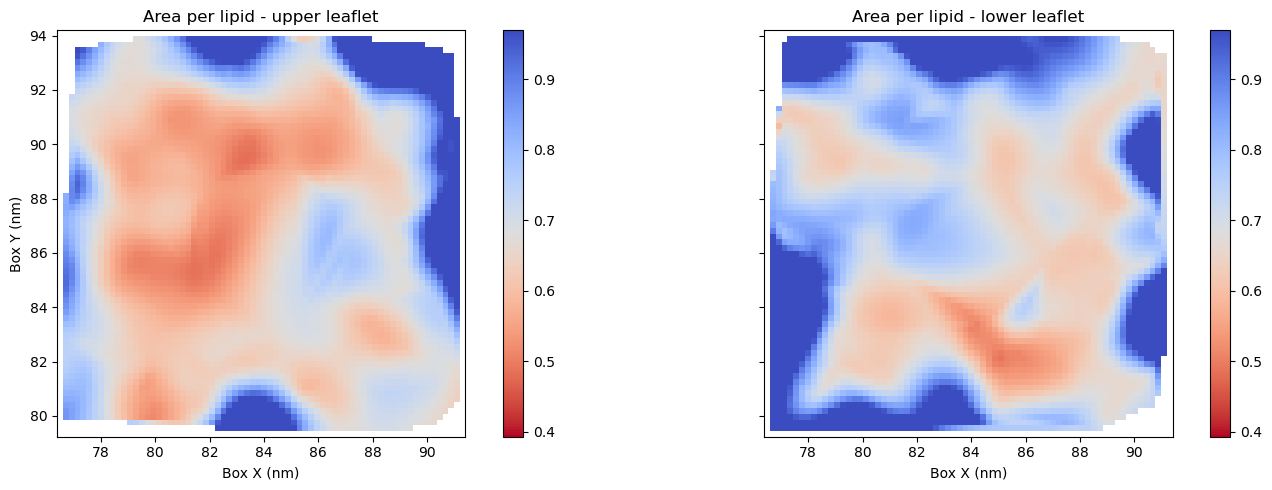

In [10]:
grid = plot_apl('out/apl.csv', hist=True)

<a id="leaflets"></a>
***
## Leafleats assignation

Lyphilic is faster that fatslim, its algorithm is simpler, assumes a plane membrane, it let you do the assignation of leafleats for every frame and use this information for analysis like flip-flop.<br>
***
**Building Blocks** used:
 - [LPPAssignLeaflets](https://biobb-mem.readthedocs.io/en/latest/lipyphilic_biobb.html#module-lipyphilic_biobb.lpp_assign_leaflets) from **from biobb_mem.lipyphilic_biobb.lpp_assign_leaflets**
***

In [16]:
from biobb_mem.lipyphilic_biobb.lpp_assign_leaflets import lpp_assign_leaflets

output_leaflets_path = 'out/leaflets_data.csv'

prop = {
    'lipid_sel': lipid_sel,
    'steps': 10,
    'disable_logs': disable_logs
}
lpp_assign_leaflets(input_top_path=input_top_path,
                    input_traj_path=input_traj_path,
                    output_leaflets_path=output_leaflets_path,
                    properties=prop)

2025-02-11 16:17:14,362 [MainThread  ] [INFO ]  Module: biobb_mem.lipyphilic_biobb.lpp_assign_leaflets Version: 5.0.6
2025-02-11 16:17:14,363 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_c9952c64-fb50-447a-80ee-6c01d788ddf6 directory successfully created
2025-02-11 16:17:14,366 [MainThread  ] [INFO ]  Copy: data/A01M6.pdb to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_c9952c64-fb50-447a-80ee-6c01d788ddf6
2025-02-11 16:17:15,498 [MainThread  ] [INFO ]  Copy: data/fit2.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_c9952c64-fb50-447a-80ee-6c01d788ddf6
2025-02-11 16:17:17,864 [MainThread  ] [INFO ]  Removed: ['/home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_c9952c64-fb50-447a-80ee-6c01d788ddf6']
2025-02-11 16:17:17,864 [MainThread  ] [INFO ]  


0

In [17]:
# A few seconds for 1000 frames
df = pd.read_csv(output_leaflets_path)
df['frame'].unique()

array([   0,    1,    2, ...,  998,  999, 1000])

In [18]:
# Leaflets visualization
from biobb_mem.lipyphilic_biobb.lpp_assign_leaflets import display_nglview
view = display_nglview(input_top_path, output_leaflets_path)
view.control.spin([0, 1, 0], -1.57)
view

NGLWidget()

<a id="flip-flop"></a>
***
## Flip-flop rate

This module provides methods for detecting the flip-flop of molecules in a lipid bilayer. A flip-flop occurs when a molecule - typically a sterol - moves from one leaflet of a bilayer into the opposing leaflet. <br>
***
**Building Blocks** used:
 - [LPPFlipFlop](https://biobb-mem.readthedocs.io/en/latest/lipyphilic_biobb.html#module-lipyphilic_biobb.lpp_flip_flop) from **from biobb_mem.lipyphilic_biobb.lpp_flip_flop**
***

In [19]:
from biobb_mem.lipyphilic_biobb.lpp_flip_flop import lpp_flip_flop

prop = {
    'lipid_sel': lipid_sel,
    'steps': 10,
    'frame_cutoff': 2,
    'disable_logs': True
}
lpp_flip_flop(input_top_path=input_top_path,
              input_traj_path=input_traj_path,
              input_leaflets_path=output_leaflets_path,
              output_flip_flop_path='out/flip_flop.csv',
              properties=prop)

  0%|          | 0/594 [00:00<?, ?it/s]

No flip-flop events found.


0

<a id="thickness"></a>
***
## Z positions and membrane thickness

Calculating the the z distance of lipids to the bilayer center and comparing it to a selection around the protein.<br>
With the z position we can calculate the membrane thickness and the local distorsion.
***
**Building Blocks** used:
 - [LPPZPositions](https://biobb-mem.readthedocs.io/en/latest/lipyphilic_biobb.html#module-lipyphilic_biobb.lpp_zpositions) from **from biobb_mem.lipyphilic_biobb.lpp_zpositions**
***

In [20]:
from biobb_mem.lipyphilic_biobb.lpp_zpositions import lpp_zpositions

# Run the analysis on the whole membrane
prop = {
    'lipid_sel': lipid_sel,
    'steps': steps,
    'height_sel': lipid_sel,
    'disable_logs': False
}

lpp_zpositions(input_top_path=input_top_path,
               input_traj_path=input_traj_path,
               output_positions_path='out/zpositions.csv',
               properties=prop)

2025-02-11 16:17:44,825 [MainThread  ] [INFO ]  Module: biobb_mem.lipyphilic_biobb.lpp_zpositions Version: 5.0.6
2025-02-11 16:17:44,826 [MainThread  ] [INFO ]  sandbox_f6ca7f0f-fab7-4058-bc40-dea59a98e9fa directory successfully created
2025-02-11 16:17:44,829 [MainThread  ] [INFO ]  Copy: data/A01M6.pdb to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_f6ca7f0f-fab7-4058-bc40-dea59a98e9fa
2025-02-11 16:17:46,050 [MainThread  ] [INFO ]  Copy: data/fit2.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_f6ca7f0f-fab7-4058-bc40-dea59a98e9fa
2025-02-11 16:17:46,257 [MainThread  ] [INFO ]  Removed: ['/home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_f6ca7f0f-fab7-4058-bc40-dea59a98e9fa']
2025-02-11 16:17:46,258 [MainThread  ] [INFO ]  


0

In [21]:
# We use MDAnalysis to select a region around the protein
# https://docs.mdanalysis.org/stable/documentation_pages/selections.html#geometric
around_sel = '(cyzone 50 70 -50 protein)'
around_resnums = u.select_atoms(around_sel).resnums
# Visualization of the selection in green
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_point(selection=ngl_sel, color='red')
view.add_point(selection=f'({", ".join(map(str, around_resnums))}) and not protein', color='green')
view.add_point(selection='protein', color='blue')
view

NGLWidget(max_frame=10000)

In [22]:
# Run the analysis on the selection around the protein
prop = {
    'lipid_sel': lipid_sel,
    'steps': steps,
    'height_sel': f'{lipid_sel} and {around_sel}',
    'disable_logs': disable_logs
}
lpp_zpositions(input_top_path=input_top_path,
            input_traj_path=input_traj_path,
            output_positions_path='out/zpositions_around.csv',
            properties=prop)

2025-02-11 16:17:58,371 [MainThread  ] [INFO ]  Module: biobb_mem.lipyphilic_biobb.lpp_zpositions Version: 5.0.6
2025-02-11 16:17:58,372 [MainThread  ] [INFO ]  sandbox_496c9286-4cdc-428e-8c41-e95d7e73326e directory successfully created
2025-02-11 16:17:58,376 [MainThread  ] [INFO ]  Copy: data/A01M6.pdb to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_496c9286-4cdc-428e-8c41-e95d7e73326e
2025-02-11 16:17:59,498 [MainThread  ] [INFO ]  Copy: data/fit2.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_496c9286-4cdc-428e-8c41-e95d7e73326e
2025-02-11 16:17:59,677 [MainThread  ] [INFO ]  Removed: ['/home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_496c9286-4cdc-428e-8c41-e95d7e73326e']
2025-02-11 16:17:59,677 [MainThread  ] [INFO ]  


0

### Plotting the thickness of the membrane

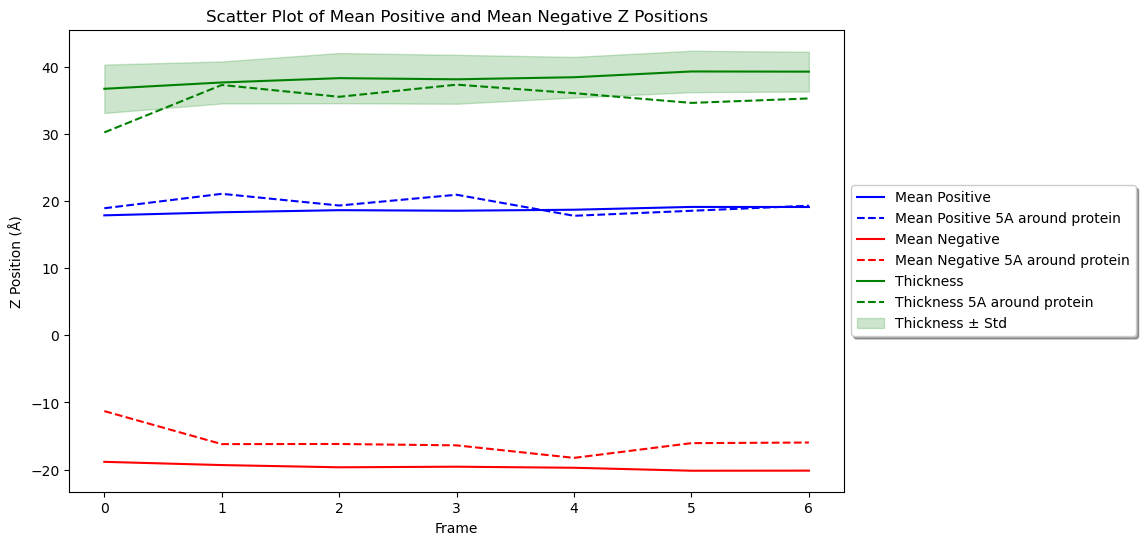

In [23]:
from biobb_mem.lipyphilic_biobb.lpp_zpositions import frame_df
import matplotlib.pyplot as plt

grouped = frame_df('out/zpositions.csv')
around = frame_df('out/zpositions_around.csv')
plt.figure(figsize=(10, 6))
# Plot the mean positive and mean negative z positions
plt.plot(grouped['mean_positive'], label='Mean Positive', linestyle='-', color='blue')
plt.plot(around['mean_positive'], label='Mean Positive 5A around protein', linestyle='--', color='blue')
plt.plot(grouped['mean_negative'], label='Mean Negative', linestyle='-', color='red')
plt.plot(around['mean_negative'], label='Mean Negative 5A around protein', linestyle='--', color='red')
plt.plot(grouped['thickness'], label='Thickness', linestyle='-', color='green')
plt.plot(around['thickness'], label='Thickness 5A around protein', linestyle='--', color='green')
plt.fill_between(grouped.index, grouped['thickness'] - grouped['std_thickness'], grouped['thickness'] + grouped['std_thickness'], color='green', alpha=0.2, label='Thickness ± Std')
plt.title('Scatter Plot of Mean Positive and Mean Negative Z Positions')
plt.ylabel('Z Position (Å)'); plt.xlabel('Frame')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, fancybox=True, shadow=True)
plt.show()

### Animating the local distorsion

In [24]:
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_ball_and_stick(selection=ngl_hd_sel,aspect_ratio=8)
view.add_cartoon(selection='protein', color='grey')
view.layout.height = '500px'
view.background = 'grey'

In [25]:
# Custom coloring scheme for the lipids with JavaScript
# https://projects.volkamerlab.org/teachopencadd/talktorials/T017_advanced_nglview_usage.html#Custom-coloring-schemes-and-representations
template = """
this.atomColor = function(atom) {
    let zPos = atom.z - %(midplane_z)f;
    let std = %(factor)f * %(std)f;
    let ratio, r, g, b, layerZ;
    
    if (zPos > 0) { // top leaflet
        layerZ = %(top_z)f;
    } else { // bottom leaflet
        layerZ = -1 * %(bot_z)f;
        zPos = -zPos;
    }
    
    if (zPos >= layerZ) { // thickening
        ratio = (zPos - layerZ) / std;
        ratio = Math.min(1, ratio);
        r = Math.floor(255 * (1 - ratio));
        g = Math.floor(255 * (1 - ratio)); 
        b = 255;
    } else { // thinning
        ratio = -(zPos - layerZ) / std;
        ratio = Math.min(1, ratio);
        r = 255;
        g = Math.floor(255 * (1 - ratio));
        b = Math.floor(255 * (1 - ratio));
    }
    return (r << 16) + (g << 8) + b;
}
"""

# Calculate the mean positive and negative (top and bottom leaflets) z positions 
# wrt the midplane of the membrane, and the standard deviation of the thickness.
top_z = grouped['mean_positive'].mean()
bot_z = grouped['mean_negative'].mean()
std   = grouped['std_thickness'].mean()
top_z, bot_z, std

# Calculate the mean z position of midplane wrt the the box axis.
midplane_z = [u.trajectory[i].positions[u.select_atoms(lipid_sel).indices].mean(axis=0)[2] for i in range(0, u.trajectory.n_frames, steps)]
def on_frame_change(change):
    frame = change['new']
    # We use the midplane  
    subframe = frame // steps
    js_function_combined = template % {
        'factor': 3, # Factor to increase the color fade
        'midplane_z': midplane_z[subframe],
        'std': std,
        'top_z': top_z,
        'bot_z': bot_z
    }
    # We have to change the color registry name to trigger the update
    nm = "local_dist"+str(frame) # One color per frame
    nv.color.ColormakerRegistry.add_scheme_func(nm, js_function_combined)
    view.update_ball_and_stick(color=nm)

In [ ]:
# Play the animation to see the color change
# Problem: the observe event stack and we have to refresh the broswer/kernel to eliminate them.
view.observe(on_frame_change, names=['frame'])
view
# RED: Thinning, BLUE: Thickening

NGLWidget(background='grey', layout=Layout(height='500px'), max_frame=10000)

<a id="order"></a>
***
## Deuterium order parameter

Calculating deuterium order parameter of acyl tails in a lipid bilayer using [gmx order](https://manual.gromacs.org/current/onlinehelp/gmx-order.html). <br>
This tool only works for saturated carbons and united atom force fields
***
**Building Blocks** used:
 - [GMXOrder](https://biobb-mem.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_order) from **from biobb_mem.gromacs.gmx_order**
***

In [26]:
with mda.selections.gromacs.SelectionWriter('data/sn1.ndx', mode='w') as ndx:
        for i in range(15,32):
            if i==16: continue
            ndx.write(u.select_atoms(f'resname DPPC and name C{i}'), name=f'C{i}')

with mda.selections.gromacs.SelectionWriter('data/sn2.ndx', mode='w') as ndx:
    for i in range(34,51):
        if i==35: continue
        ndx.write(u.select_atoms(f'resname DPPC and name C{i}'), name=f'C{i}')

In [27]:
from biobb_mem.gromacs.gmx_order import gmx_order

prop = {
    'd':'z',
    'disable_logs': disable_logs,
}
gmx_order(input_top_path=input_tpr_path,
          input_traj_path=input_traj_path,
          input_index_path='data/sn1.ndx',
          output_deuter_path='out/deuter_sn1.xvg',
          properties=prop)

gmx_order(input_top_path=input_tpr_path,
          input_traj_path=input_traj_path,
          input_index_path='data/sn2.ndx',
          output_deuter_path='out/deuter_sn2.xvg',
          properties=prop)

2025-02-11 16:18:12,332 [MainThread  ] [INFO ]  Module: biobb_mem.gromacs.gmx_order Version: 5.0.6
2025-02-11 16:18:12,332 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e566259b-6556-4901-8f00-9a65fe061ff0 directory successfully created
2025-02-11 16:18:12,339 [MainThread  ] [INFO ]  Copy: data/A01M6.tpr to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e566259b-6556-4901-8f00-9a65fe061ff0
2025-02-11 16:18:13,450 [MainThread  ] [INFO ]  Copy: data/fit2.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e566259b-6556-4901-8f00-9a65fe061ff0
2025-02-11 16:18:13,451 [MainThread  ] [INFO ]  Copy: data/sn1.ndx to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e566259b-6556-4901-8f00-9a65fe061ff0
2025-02-11 16:18:13,451 [MainThread  ] [INFO ]  gmx order -s /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e566259b-6556-4901-8f00-9a65fe061ff0/A01M6.tpr -f /home/rchaves/repo/biobb_wf_mem/bio

0

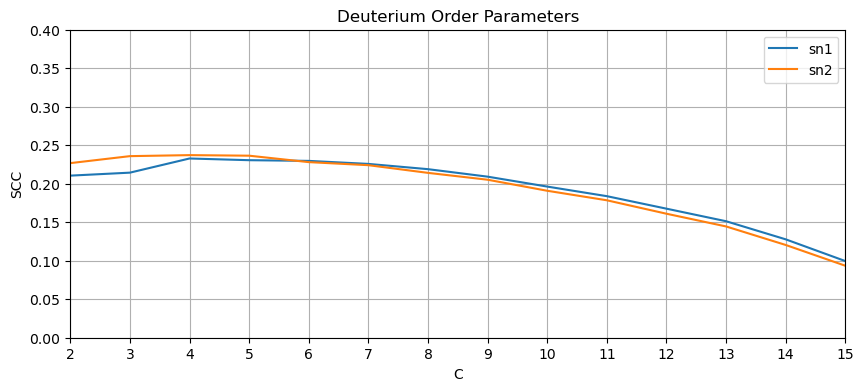

In [28]:
# Read the XVG file
data = np.loadtxt('out/deuter_sn1.xvg', comments=['@', '#'])
data2 = np.loadtxt('out/deuter_sn2.xvg', comments=['@', '#'])

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(data[:, 0]+1, data[:, 1])
plt.plot(data2[:, 0]+1, data2[:, 1])
plt.xlabel('C'); plt.ylabel('SCC')
plt.title('Deuterium Order Parameters')

# It is not possible to compute -SCD for terminal carbon atoms, 
# as they lack neighboring atoms from which the local molecular 
# axis is computed
plt.ylim(0,.4); plt.xlim(2,15)
plt.xticks(range(2,16))
plt.legend(['sn1','sn2'])
plt.grid(True); plt.show()

<a id="density"></a>
***
## Density profile

Calculating the density over an axis with [amber selection masks](https://amberhub.chpc.utah.edu/atom-mask-selection-syntax/).<br>
***
**Building Blocks** used:
 - [CpptrajDensity](https://biobb-mem.readthedocs.io/en/latest/ambertools.html#module-ambertools.cpptraj_density) from **biobb_mem.ambertools.cpptraj_density**
***

In [2]:
from biobb_mem.ambertools.cpptraj_density import cpptraj_density

prop = {
    'mask': '::M ::A,B,C,D  @P8',
    'steps': steps,
    'disable_logs': disable_logs
}
cpptraj_density(input_top_path=input_top_path,
            input_traj_path=input_traj_path,
            output_cpptraj_path='out/density.dat',
            properties=prop)

2025-02-11 16:24:37,548 [MainThread  ] [INFO ]  Module: biobb_mem.ambertools.cpptraj_density Version: 5.0.6
2025-02-11 16:24:37,549 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_68eaef2b-680d-4dc3-bb2f-f54951d5e4ab directory successfully created


2025-02-11 16:24:37,552 [MainThread  ] [INFO ]  Copy: data/A01M6.pdb to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_68eaef2b-680d-4dc3-bb2f-f54951d5e4ab
2025-02-11 16:24:38,805 [MainThread  ] [INFO ]  Copy: data/A01M6.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_68eaef2b-680d-4dc3-bb2f-f54951d5e4ab
2025-02-11 16:24:38,806 [MainThread  ] [INFO ]  cpptraj -i 8895afd0-7af3-42ad-8229-9377d938ed56/instructions.in

2025-02-11 16:24:38,936 [MainThread  ] [INFO ]  Executing: cpptraj -i 8895afd0-7af3-42ad-8229-9377d938ed56/instructions.in...
2025-02-11 16:24:38,937 [MainThread  ] [INFO ]  Exit code: 0
2025-02-11 16:24:38,937 [MainThread  ] [INFO ]  
CPPTRAJ: Trajectory Analysis. V6.18.1 (AmberTools)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 02/11/25 16:24:38
| Available memory: 5.117 GB

INPUT: Reading input from '8895afd0-7af3-42ad-8229-9377d938ed56/instructions.in'
  [parm /home/rchaves/repo/biobb_wf_mem/biob

0

In [28]:
# Function to visualize the density results
def plot_and_view(df, view, labels):
    axis = df.columns[0] # Axis the density was calculated on
    cls = df.columns[1:] # Mask used and std. EX: ::M	sd(::M)	::A,B	sd(::A,B)
    fig = make_subplots(rows=1, cols=1, subplot_titles=['Mass Density'])
    # Iterate over the columns
    for i in range(0,len(cls),2): # Density of each mask
        fig.add_trace(go.Scatter(x=df[axis], y=df[cls[i]], mode='lines', name=labels[i // 2]), row=1, col=1)
    # Standard deviation
    for i in range(1,len(cls)+1,2): 
        # Add a transparent line plot for the standard deviation
        fig.add_trace(go.Scatter(x=df[axis], y=df[cls[i-1]] - df[cls[i]], mode='lines', fill=None, showlegend=False, line=dict(color='rgba(0,0,0,0)')), row=1, col=1)
        fig.add_trace(go.Scatter(x=df[axis], y=df[cls[i-1]] + df[cls[i]], mode='lines', fill='tonexty', name=f'{labels[i // 2]} STD', line=dict(color='rgba(0,0,0,0)'), fillcolor='rgba(0,100,80,0.2)'), row=1, col=1)
    
    fig.update_layout(
        xaxis_title='Å', 
        yaxis_title='Density', 
        legend=dict(orientation="h",
            yanchor="bottom", y=-0.5, xanchor="auto",
            entrywidth=0.33, entrywidthmode='fraction',
            traceorder="normal"),
        height=400, # Make figure smaller by setting fixed height
        margin=dict(l=40, r=40, t=40, b=40)
    )
    display(fig)
    # Set the size of the NGL view widget and its orientation
    view.remove_ball_and_stick()
    view.update_cartoon(color='red')
    view.add_point(selection=ngl_sel, color='blue')
    view.add_ball_and_stick(selection=ngl_hd_sel, color='green',aspect_ratio=4) # headgroups
    view.background = 'black'
    view.layout.width = '100%'
    display(view)
    view.control.spin([0, 1, 0], -1.57)  # Same orientation as the plot
    #view._remote_call('setSize', target='Widget', args=['100%', '100%'])

In [29]:
view = nv.show_file(input_top_path)
den = pd.read_csv(f'out/density.dat', sep='\s+')
plot_and_view(den,view,['Membrane','Protein','P8'])

NGLWidget(background='black', layout=Layout(width='100%'))

<a id="channel"></a>
***
## Channel dimensions

Analyze pore dimensions and properties along a channel or transporter pathway.<br>
***
**Building Blocks** used:
 - [MDAHole](https://biobb-mem.readthedocs.io/en/latest/mdanalysis_biobb.html#mdanalysis_biobb.mda_hole.MDAHole) from **from biobb_mem.mdanalysis_biobb.mda_hole**
***

In [32]:
from biobb_mem.mdanalysis_biobb.mda_hole import mda_hole

prop = {
    'select': 'protein',
    'steps': steps,
    'sample': 0.1,
    'disable_logs': disable_logs
}
mda_hole(input_top_path=input_top_path,
         input_traj_path=input_traj_path,
         output_hole_path='out/hole.vmd',
         output_csv_path='out/hole_profile.csv',
         properties=prop)

2025-02-11 16:19:12,530 [MainThread  ] [INFO ]  Module: biobb_mem.mdanalysis_biobb.mda_hole Version: 5.0.6
2025-02-11 16:19:12,531 [MainThread  ] [INFO ]  /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_30ac092b-fb0f-4d10-bb87-d18f58853ffd directory successfully created
2025-02-11 16:19:12,534 [MainThread  ] [INFO ]  Copy: data/A01M6.pdb to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_30ac092b-fb0f-4d10-bb87-d18f58853ffd
2025-02-11 16:19:13,618 [MainThread  ] [INFO ]  Copy: data/fit2.xtc to /home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_30ac092b-fb0f-4d10-bb87-d18f58853ffd


/home/rchaves/miniforge3/envs/biobb_wf_mem/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning:

Found no information for attr: 'formalcharges' Using default value of '0'

/home/rchaves/miniforge3/envs/biobb_wf_mem/lib/python3.11/site-packages/MDAnalysis/lib/util.py:575: DeprecationWarning:

This method is deprecated as of MDAnalysis version 2.7.0 and will be removed in version 3.0.0. Please use shutil.which instead.



2025-02-11 16:19:24,329 [MainThread  ] [INFO ]  Removed: ['/home/rchaves/repo/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_30ac092b-fb0f-4d10-bb87-d18f58853ffd']
2025-02-11 16:19:24,329 [MainThread  ] [INFO ]  


0

In [33]:
# Load the CSV file
df = pd.read_csv('out/hole_profile.csv')
frames = df['Frame'].unique()

# Create a figure
fig = go.Figure()

# Add traces for each frame
for frame in frames:
    frame_data = df[df['Frame'] == frame]
    fig.add_trace(go.Scatter(x=frame_data['Pore Coordinate'], y=frame_data['Radius'], mode='lines', name=f'Frame {frame}'))

# Update layout
fig.update_layout(
    title='Pore Radius vs Pore Coordinate',
    xaxis_title='Pore Coordinate (Å)',
    yaxis_title='Radius (Å)',
    legend_title='Frame'
)

# Show the figure
fig.show()

In [34]:
from biobb_mem.mdanalysis_biobb.mda_hole import display_hole
display_hole(input_top_path, input_traj_path, output_hole_path='out/hole.vmd', opacity=0.9,frame=0)

NGLWidget(max_frame=10000)

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)
    * [https://github.com/bioexcel/biobb_wf_mem/issues](https://github.com/bioexcel/biobb_wf_mem/issues)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)

* Mail:
    * [ruben.chaves@irbbarcelona.org](mailto:ruben.chaves@irbbarcelona.org)